In [1]:
import sys
print(sys.path)

['/vision/u/ianhuang/anaconda3/envs/.vidobj_new/lib/python36.zip', '/vision/u/ianhuang/anaconda3/envs/.vidobj_new/lib/python3.6', '/vision/u/ianhuang/anaconda3/envs/.vidobj_new/lib/python3.6/lib-dynload', '', '/vision/u/ianhuang/anaconda3/envs/.vidobj_new/lib/python3.6/site-packages', '/vision/u/ianhuang/anaconda3/envs/.vidobj_new/lib/python3.6/site-packages/pycocotools-2.0-py3.6-linux-x86_64.egg', '/vision/u/ianhuang/anaconda3/envs/.vidobj_new/lib/python3.6/site-packages/apex-0.1-py3.6-linux-x86_64.egg', '/vision2/u/ianhuang/VidObjClassHierarchy/utilities/maskrcnn-benchmark/maskrcnn-benchmark', '/vision2/u/ianhuang/anaconda3/envs/.vidobj_new/lib/python3.6/site-packages', '/vision/u/ianhuang/anaconda3/envs/.vidobj_new/lib/python3.6/site-packages/IPython/extensions', '/sailhome/ianhuang/.ipython']


In [2]:
sys.executable

'/vision/u/ianhuang/anaconda3/envs/.vidobj_new/bin/python'

In [3]:
pwd

'/vision2/u/ianhuang/VidObjClassHierarchy/viz/viz_data'

In [4]:
cd ../../utilities/obman_train

/vision2/u/ianhuang/VidObjClassHierarchy/utilities/obman_train


In [5]:
ls

assets/              LICENSE      __pycache__/     release_models.zip
environment.yml      mano/        pyproject.toml   scripts/
handobjectdatasets/  manopth/     readme_assets/   traineval.py
image_demo.py        mano_train/  README.md        webcam_demo.py
__init__.py*         misc/        release_models/


In [7]:
import argparse
import os
import pickle

import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

from handobjectdatasets.queries import TransQueries, BaseQueries

from mano_train.exputils import argutils
from mano_train.netscripts.reload import reload_model
from mano_train.visualize import displaymano
from mano_train.demo.preprocess import prepare_input, preprocess_frame

# Trying the model on their data

In [8]:
resume = "release_models/obman/checkpoint.pth.tar"
image_path = "readme_assets/images/can.jpg"
no_beta = True

checkpoint = os.path.dirname(resume)
with open(os.path.join(checkpoint, "opt.pkl"), "rb") as opt_f:
    opts = pickle.load(opt_f)

# Initialize network
model = reload_model(resume, opts, no_beta=no_beta)

model.eval()

=> loading checkpoint 'release_models/obman/checkpoint.pth.tar'
=> loading checkpoint 'release_models/obman/checkpoint.pth.tar'


Traceback (most recent call last):
  File "/vision2/u/ianhuang/VidObjClassHierarchy/utils/obman_train/mano_train/netscripts/reload.py", line 101, in reload_model
    modelio.load_checkpoint(model, resume_path=model_path, strict=True)
  File "/vision2/u/ianhuang/VidObjClassHierarchy/utils/obman_train/mano_train/modelutils/modelio.py", line 60, in load_checkpoint
    model.load_state_dict(state_dict, strict=strict)
  File "/sailhome/ianhuang/anaconda3/envs/obman_train/lib/python3.7/site-packages/torch/nn/modules/module.py", line 777, in load_state_dict
    self.__class__.__name__, "\n\t".join(error_msgs)))
RuntimeError: Error(s) in loading state_dict for DataParallel:
	Unexpected key(s) in state_dict: "module.mano_branch.shape_reg.0.weight", "module.mano_branch.shape_reg.0.bias". 
/vision2/u/ianhuang/VidObjClassHierarchy/utils/obman_train/mano_train/netscripts/reload.py:105: UserWarning: Couldn' load model in strict mode, trying without strict
  "Couldn' load model in strict mode, trying

DataParallel(
  (module): HandNet(
    (base_net): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64

In [8]:
with open("misc/mano/MANO_RIGHT.pkl", "rb") as p_f:
        mano_right_data = pickle.load(p_f, encoding="latin1")
        faces = mano_right_data["f"]

In [10]:
frame = cv2.imread(image_path)
frame = preprocess_frame(frame)
input_image = prepare_input(frame)

In [19]:

def forward_pass_3d(model, input_image, pred_obj=True):
    sample = {}
    sample[TransQueries.images] = input_image
    sample[BaseQueries.sides] = ["left"]
    sample[TransQueries.joints3d] = input_image.new_ones((1, 21, 3)).float()
    sample["root"] = "wrist"
    if pred_obj:
        sample[TransQueries.objpoints3d] = input_image.new_ones(
            (1, 600, 3)
        ).float()
    _, results, _ = model.forward(sample, no_loss=True)

    return results

In [20]:
img = Image.fromarray(frame.copy())
hand_crop = cv2.resize(np.array(img), (256, 256))
noflip_hand_image = prepare_input(hand_crop, flip_left_right=False)
flip_hand_image = prepare_input(hand_crop, flip_left_right=True)
noflip_output = forward_pass_3d(model, noflip_hand_image)
flip_output = forward_pass_3d(model, flip_hand_image)
flip_verts = flip_output["verts"].cpu().detach().numpy()[0]
noflip_verts = noflip_output["verts"].cpu().detach().numpy()[0]

In [22]:
flip_output.keys()

dict_keys(['verts', 'joints', 'shape', 'pose', 'contact_info', 'objpoints3d', 'objtrans', 'objpointscentered3d', 'objfaces', 'objscale'])

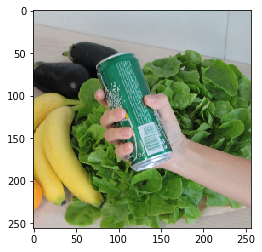

In [31]:
plt.imshow(hand_crop[...,::-1])

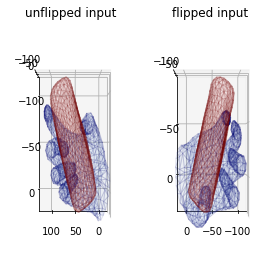

In [27]:
fig = plt.figure(figsize=(4,4))
fig.clf()
ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.title.set_text("unflipped input")
displaymano.add_mesh(ax, flip_verts, faces, flip_x=True)
if "objpoints3d" in flip_output:
    objverts = flip_output["objpoints3d"].cpu().detach().numpy()[0]
    displaymano.add_mesh(
        ax, objverts, flip_output["objfaces"], flip_x=True, c="r"
    )
ax = fig.add_subplot(1, 2, 2, projection="3d")
ax.title.set_text("flipped input")
displaymano.add_mesh(ax, noflip_verts, faces, flip_x=True)
if "objpoints3d" in noflip_output:
    objverts = noflip_output["objpoints3d"].cpu().detach().numpy()[0]
    displaymano.add_mesh(
        ax, objverts, noflip_output["objfaces"], flip_x=True, c="r"
    )

# Trying it on our data

In [34]:
import random

In [43]:
all_files = os.listdir('../../viz/viz_data/tmp_dataset/P01/P01_01/')
file_names = [all_files[random.randint(0, len(all_files))] for i in range(1)]
video_sources = [os.path.join('../../viz/viz_data/tmp_dataset/P01/P01_01/', element) for element in file_names]
video_sources

['../../viz/viz_data/tmp_dataset/P01/P01_01/0000092821.jpg']

In [ ]:
crops = [[125, 250], [150, 250]]

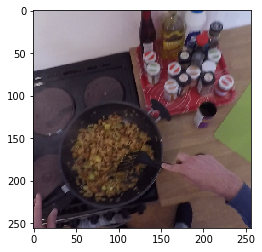

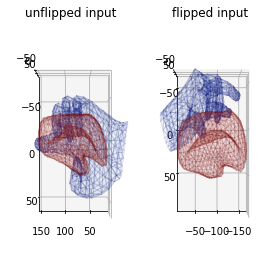

In [49]:
for idx, element in enumerate(video_sources):
    frame = cv2.imread(element)
    frame = preprocess_frame(frame)
    img = Image.fromarray(frame.copy())
    hand_crop = cv2.resize(np.array(img), (256, 256))
    
    hand_crop = cv2.resize(hand_crop[125: 250, 150:250,:], (256, 256))
    
    plt.imshow(frame[...,::-1])
    
    noflip_hand_image = prepare_input(hand_crop, flip_left_right=False)
    flip_hand_image = prepare_input(hand_crop, flip_left_right=True)
    noflip_output = forward_pass_3d(model, noflip_hand_image)
    flip_output = forward_pass_3d(model, flip_hand_image)
    flip_verts = flip_output["verts"].cpu().detach().numpy()[0]
    noflip_verts = noflip_output["verts"].cpu().detach().numpy()[0]
    
    fig = plt.figure(figsize=(4,4))
    fig.clf()
    ax = fig.add_subplot(1, 2, 1, projection="3d")
    ax.title.set_text("unflipped input")
    displaymano.add_mesh(ax, flip_verts, faces, flip_x=True)
    if "objpoints3d" in flip_output:
        objverts = flip_output["objpoints3d"].cpu().detach().numpy()[0]
        displaymano.add_mesh(
            ax, objverts, flip_output["objfaces"], flip_x=True, c="r"
        )
    ax = fig.add_subplot(1, 2, 2, projection="3d")
    ax.title.set_text("flipped input")
    displaymano.add_mesh(ax, noflip_verts, faces, flip_x=True)
    if "objpoints3d" in noflip_output:
        objverts = noflip_output["objpoints3d"].cpu().detach().numpy()[0]
        displaymano.add_mesh(
            ax, objverts, noflip_output["objfaces"], flip_x=True, c="r"
        )